# CerealTimeKillersNet: Deep neural network for emotional states predictions from EEG data.

## Setup

In [1]:
# Packages & self-implemented functions
from CTKNetFunctions import *


## Model settings - Change models here!

In [2]:
class CTKNet_RNN(nn.Module):
    def __init__(self, input_shape, out_size):

        super(CTKNet_RNN, self).__init__()
        
        # Model hyperparametres (layer by layer)
        rnn_layer = [1]
        rnn_unit = [128]
        rnn_drop = [0]
        fc_unit = [64]
        drop_out = [0.5]
        
        self.rnn_layer = rnn_layer
        self.rnn_unit = rnn_unit
        
        # Hidden layers
        img_size = np.array(input_shape[2:])
        
        fc_input_size = np.int(np.prod(img_size) * input_shape[1])
        
        self.rnn1 = nn.LSTM(input_size = fc_input_size, hidden_size = rnn_unit[0], num_layers = rnn_layer[0], dropout = rnn_drop[0], batch_first = True)
        
        self.fc1 = nn.Linear(in_features = rnn_unit[0] * rnn_layer[0], out_features = fc_unit[0])
        self.drop1 = nn.Dropout(drop_out[0])
        
        self.fc2 = nn.Linear(in_features = fc_unit[0], out_features = out_size[0])
        

    def forward(self, x):
        
        shape = x.shape
        x = x.view(shape[0] * shape[1], shape[2], shape[3], shape[4])
        
        hidden = (torch.randn(self.rnn_layer[0], shape[0], self.rnn_unit[0]), 
                  torch.randn(self.rnn_layer[0], shape[0], self.rnn_unit[0]))   # for LSTM
        # hidden = torch.randn(self.rnn_layer[0], shape[0], self.rnn_unit[0])   # for simple RNN and GRU
        
        x = torch.flatten(x, 1)        
        x = x.view(shape[0], shape[1], -1)
        _, x = self.rnn1(x, hidden) # use final hidden state for non-series label prediction!
        x = x[0].permute(1, 0, 2) # for LSTM
        # x = x.permute(1, 0, 2) # for simple RNN and GRU
        x = F.relu(x)
        x = x.contiguous().view(x.shape[0], -1)
        
        x = self.fc1(x)
        x = self.drop1(x)
        x = F.relu(x)
        
        x = self.fc2(x)
        x = F.sigmoid(x)
        
        return x
    

In [3]:
# Model selection function
def CerealTimeKillersModelGenerator(args, size):
    
    model = CTKNet_RNN(input_shape = size[0], out_size = size[1])
    optimizer = optim.SGD(model.parameters(), lr = args['lr'], momentum = args['momentum'])
    criterion = nn.MSELoss()
    
    return model, optimizer, criterion


In [4]:
# Main function of model simulation
def CerealTimeKillersModelSimulator(args, label,
                                    TrainDataLoader, ValDataLoader, TestDataLoader, DataSize,
                                    is_2D = False,
                                    K_fold_train = False, k_folds = 1):
    
    N_FOLD = k_folds if K_fold_train else 1
    loss, acc, param, models = [], [], [], []
    
    for fold in range(N_FOLD):
        print('\n%d/%d Fold' % (fold + 1, N_FOLD))
        print('----------------------------')
    
        model, optimizer, criterion = CerealTimeKillersModelGenerator(args, size = DataSize)
        loss_list, acc_list, param_norm_list, trained_model, epoch = simulation(args, label, model,
                                                                                TrainDataLoader[fold],
                                                                                ValDataLoader[fold],
                                                                                TestDataLoader,
                                                                                is_2D = is_2D,
                                                                                optimizer = optimizer,
                                                                                criterion = criterion)
    
        loss_list, acc_list = np.array(loss_list), np.array(acc_list)
        loss.append([loss_list[0, epoch], loss_list[1, epoch], loss_list[2, epoch]])
        acc.append([acc_list[0, epoch], acc_list[1, epoch], acc_list[2, epoch]])
        param.append(param_norm_list[epoch])
        models.append(trained_model)
        
        print('Train/Val/Test Final MSE:', list(loss[-1]))
        print('Train/Val/Test Maximum Accuracy:', list(acc[-1]))
    
    return loss, acc, param, models



## Input settings - Change hypermatres here!

In [5]:
class CerealTimeKillersLabels:
    """
    Select labels for model prediction
    Labels used for prediction: info + electrode --> prediction
    CHANGE these with necessity before loading data
    """
    
    # ['subject', 'game', 'gender', 'age', 'disturbance', 'experience', 'memory']
    info = []
        
    # ['AF3', 'AF4', 'F3', 'F4', 'F7', 'F8', 'FC5', 'FC6', 'O1', 'O2', 'P7', 'P8', 'T7', 'T8']
    electrode = ['AF3', 'AF4', 'F3', 'F4', 'F7', 'F8', 'FC5', 'FC6', 'O1', 'O2', 'P7', 'P8', 'T7', 'T8']
        
    # ['satisfied', 'boring', 'horrible', 'calm', 'funny', 'valence', 'arousal']
    prediction = ['boring', 'horrible', 'calm', 'funny']
    # prediction = ['valence', 'arousal']
    
    # Quadrant emotions (applied after predicting valence/arousal)
    quadrant = ['boring', 'horrible', 'calm', 'funny']
    
    # Fixed variables
    fixed = info + prediction
    
    # Summarise labels for model
    label = info + electrode + prediction


In [6]:
# General settings
workspace_dir = '' # Workspace directionary
LabelRange = [1, 10] # The [min, max] of emotional states for transformation

# Whether to allow between-window dataset mixture
# SET TO FALSE FOR 4-DIMENSIONAL INPUT WHEN USING RNN
Is_between_subject = False # Default is True for 3-dimensional input

# Whether to transform 2D emotion  (valence/arousal) to 4 quardrant emotions ()
Is_2D_to_quardrant_emotion = False # Default is False

# Which to be based for allocating testing dataset (only when Is_between_subject = True)
Allocation_test = None # [None, 'subject', 'game'] # Default is None
test_ratio = 0.2 # Proportion of data used for testing when Allocation_test == None
Target_test = [25, 26, 27] # Int list for allocating corresponding game/subject as testing dataset when Allocation_test != None

# Model structural settings
N_inputtime = 1 # Time window for input sampling (Default is None for the whole timepoints)
N_stridetime = 1 # Temporal leap for input sampling when N_inputtime != None
N_perseg = 256 # N per seg of spectrogram
N_framerate = 128 # Framerate of spectrogram

# Model training settings
batch_size_train = 16 # Number of examples per minibatch during training
batch_size_test = 1 # Number of examples per minibatch during validation/testing
k_folds = 5 # Number for K-folds for training vs validation (validation is 1/k_folds of the train/val set)
K_fold_train = True # Whether enable the full K-fold cross-validation for training (if False, validate only once)

# Model hypermparametres
args = {
    'epochs': 300,
    'lr': 3e-3,
    'momentum': 0.99,
    'l1': 1e-3,
    'l2': 1e-3,
    'patience': 30,
    'device': set_device(),
}
print('Current device:', args['device'])

# Set random seed for reproducibility
SEED = 2021
set_seed(seed = SEED)
g_seed = torch.Generator()
g_seed.manual_seed(SEED)

# Torch-based data transformation
data_transform = None


Current device: cpu
Random seed 2021 has been set.


## MAIN CODE

In [7]:
# Implement Dataloader
FullDataset, DataSize, ExpIndex = CerealTimeKillersDataLoader(dir_base = workspace_dir,
                                                              label_class = CerealTimeKillersLabels,
                                                              label_range = LabelRange,
                                                              dataset_mix = Is_between_subject,
                                                              winlen = N_inputtime,
                                                              stride = N_stridetime,
                                                              nperseg = N_perseg,
                                                              fs = N_framerate,
                                                              transform = data_transform)

# Implement DataSplitter
SplittedDataset, SplittedDataLength = CerealTimeKillersDataSplitter(FullDataset, 
                                                                    exp_index = ExpIndex, 
                                                                    allocation_test = Allocation_test,
                                                                    test_ratio = test_ratio,
                                                                    target_test = Target_test,
                                                                    k_folds = k_folds,
                                                                    batch_size_train = batch_size_train,
                                                                    batch_size_test = batch_size_test,
                                                                    seed = SEED,
                                                                    generator = g_seed)

# Load Splited data
(TrainDataLoader, ValDataLoader, TestDataLoader) = (SplittedDataset['train'],
                                                    SplittedDataset['val'],
                                                    SplittedDataset['test'])

# Show data size
print('Dataset length:', SplittedDataLength)
print('Input shape: [channel, frequency, time]')
print('Single input data size:', DataSize[0])
print('Single output data size:', DataSize[1])


Dataset length: {'train': 70, 'val': 17, 'test': 21}
Input shape: [channel, frequency, time]
Single input data size: (169, 14, 129, 1)
Single output data size: (4,)


In [8]:
# Model selection
model, optimizer, criterion = CerealTimeKillersModelGenerator(args, size = DataSize)
print(model)
# summary(model, DataSize[0])


CTKNet_RNN(
  (rnn1): LSTM(1806, 128, batch_first=True)
  (fc1): Linear(in_features=128, out_features=64, bias=True)
  (drop1): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=64, out_features=4, bias=True)
)



1/5 Fold
----------------------------


/Users/chronowanderer/.local/lib/python3.7/site-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


-----Epoch  10 / 300
Train/Val/TEST MSE: 0.12492762058973313 0.12264115177094936 0.12081020316552549
Train/Val/TEST Accuracy: 39.130434782608695 50.0 14.285714285714286
-----Epoch  20 / 300
Train/Val/TEST MSE: 0.10333725214004516 0.09155915015273625 0.1080498466534274
Train/Val/TEST Accuracy: 53.6231884057971 38.888888888888886 33.333333333333336
-----Epoch  30 / 300
Train/Val/TEST MSE: 0.0947003960609436 0.08383896232893069 0.11163273817371755
Train/Val/TEST Accuracy: 42.028985507246375 38.888888888888886 33.333333333333336
-----Epoch  40 / 300
Train/Val/TEST MSE: 0.0973849669098854 0.08444854927559693 0.11273989855267462
Train/Val/TEST Accuracy: 44.927536231884055 33.333333333333336 28.571428571428573
-----Epoch  50 / 300
Train/Val/TEST MSE: 0.10196062177419662 0.08784733660933045 0.11149363374958436
Train/Val/TEST Accuracy: 49.27536231884058 44.44444444444444 23.80952380952381
-----Epoch  60 / 300
Train/Val/TEST MSE: 0.09605789333581924 0.08790527749806643 0.11127759680329334
Train/

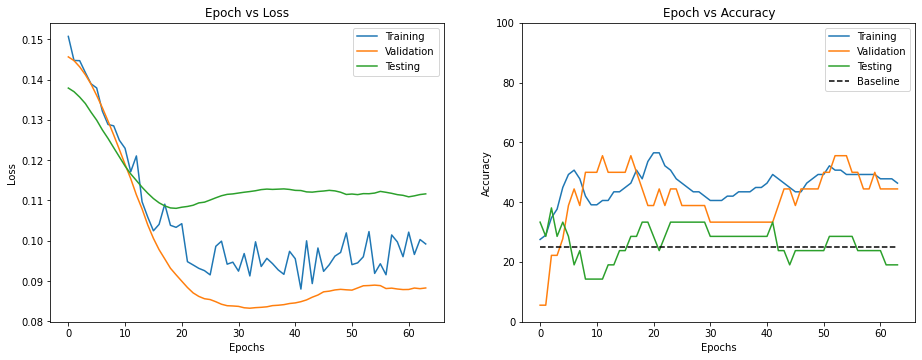

Train/Val/Test Final MSE: [0.09128645211458206, 0.08328337791479296, 0.11221475021115371]
Train/Val/Test Maximum Accuracy: [40.57971014492754, 33.333333333333336, 28.571428571428573]

2/5 Fold
----------------------------


-----Epoch  10 / 300
Train/Val/TEST MSE: 0.1274167701601982 0.1104242234594292 0.12215486567999635
Train/Val/TEST Accuracy: 44.927536231884055 22.22222222222222 28.571428571428573
-----Epoch  20 / 300
Train/Val/TEST MSE: 0.10494702607393265 0.08906528519259559 0.10999515705874988
Train/Val/TEST Accuracy: 43.47826086956522 16.666666666666668 14.285714285714286
-----Epoch  30 / 300
Train/Val/TEST MSE: 0.0960782840847969 0.08701682204587592 0.11278686282180604
Train/Val/TEST Accuracy: 46.3768115942029 27.77777777777778 14.285714285714286
-----Epoch  40 / 300
Train/Val/TEST MSE: 0.09727789759635926 0.08814980151752631 0.11412523092613333
Train/Val/TEST Accuracy: 44.927536231884055 33.333333333333336 14.285714285714286
-----Epoch  50 / 300
Train/Val/TEST MSE: 0.09117510914802551 0.08753709733072254 0.11188490059049357
Train/Val/TEST Accuracy: 42.028985507246375 27.77777777777778 14.285714285714286
-----Epoch  60 / 300
Train/Val/TEST MSE: 0.09459174126386642 0.08742498171826203 0.11131611342

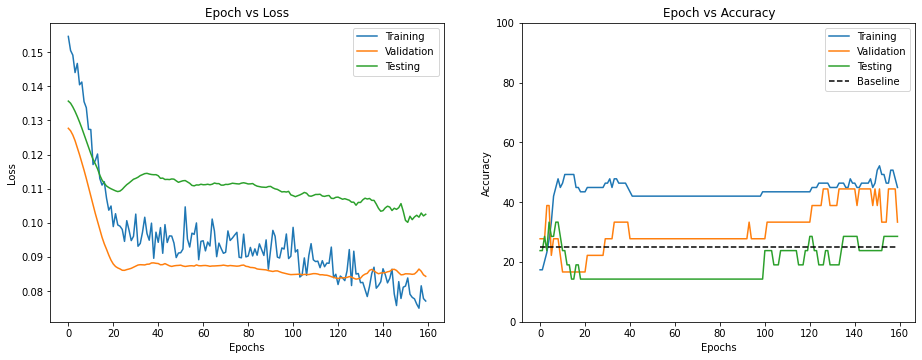

Train/Val/Test Final MSE: [0.08500764071941376, 0.08350886849479543, 0.10517287941738254]
Train/Val/Test Maximum Accuracy: [46.3768115942029, 44.44444444444444, 23.80952380952381]

3/5 Fold
----------------------------


-----Epoch  10 / 300
Train/Val/TEST MSE: 0.11799207776784897 0.1283771588521845 0.1237067205033132
Train/Val/TEST Accuracy: 42.857142857142854 52.94117647058823 14.285714285714286
-----Epoch  20 / 300
Train/Val/TEST MSE: 0.09676725566387176 0.11298922712312025 0.1115989148439396
Train/Val/TEST Accuracy: 38.57142857142857 41.1764705882353 19.047619047619047
-----Epoch  30 / 300
Train/Val/TEST MSE: 0.09720032066106796 0.11095027406426038 0.11352228155980508
Train/Val/TEST Accuracy: 37.142857142857146 41.1764705882353 28.571428571428573
-----Epoch  40 / 300
Train/Val/TEST MSE: 0.09369241446256638 0.11217599000562639 0.11792689748108387
Train/Val/TEST Accuracy: 47.142857142857146 52.94117647058823 19.047619047619047
-----Epoch  50 / 300
Train/Val/TEST MSE: 0.0921137124300003 0.11324900246280081 0.1166416560521438
Train/Val/TEST Accuracy: 44.285714285714285 41.1764705882353 28.571428571428573
-----Epoch  60 / 300
Train/Val/TEST MSE: 0.0916142463684082 0.1134705736356623 0.11556769845386346


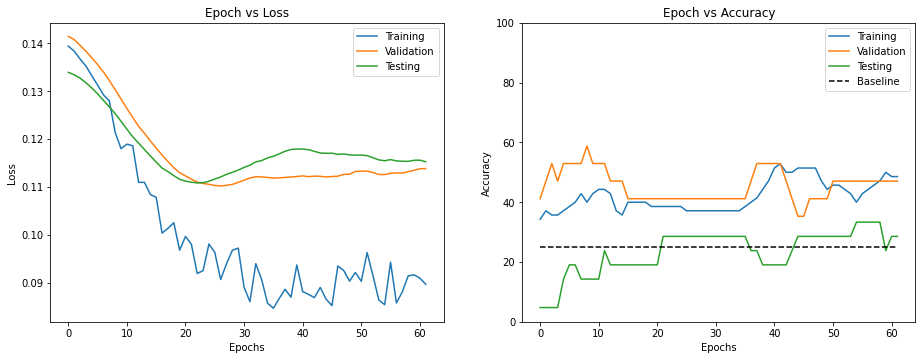

Train/Val/Test Final MSE: [0.08900855630636215, 0.1114079234573771, 0.11408451855892227]
Train/Val/Test Maximum Accuracy: [37.142857142857146, 41.1764705882353, 28.571428571428573]

4/5 Fold
----------------------------


-----Epoch  10 / 300
Train/Val/TEST MSE: 0.12338698357343673 0.12658121151959195 0.12295539189307463
Train/Val/TEST Accuracy: 41.42857142857143 41.1764705882353 14.285714285714286
-----Epoch  20 / 300
Train/Val/TEST MSE: 0.09683281183242798 0.10878454937654383 0.11037880208875452
Train/Val/TEST Accuracy: 42.857142857142854 41.1764705882353 19.047619047619047
-----Epoch  30 / 300
Train/Val/TEST MSE: 0.0908433049917221 0.10215598081841189 0.11036674350145317
Train/Val/TEST Accuracy: 45.714285714285715 41.1764705882353 19.047619047619047
-----Epoch  40 / 300
Train/Val/TEST MSE: 0.09070691466331482 0.10323372461340007 0.11361949451799903
Train/Val/TEST Accuracy: 41.42857142857143 41.1764705882353 19.047619047619047
-----Epoch  50 / 300
Train/Val/TEST MSE: 0.09044076055288315 0.10358082963263288 0.11461345784898315
Train/Val/TEST Accuracy: 38.57142857142857 41.1764705882353 14.285714285714286
-----Epoch  60 / 300
Train/Val/TEST MSE: 0.09062807559967041 0.10415010296684854 0.1139626124696362

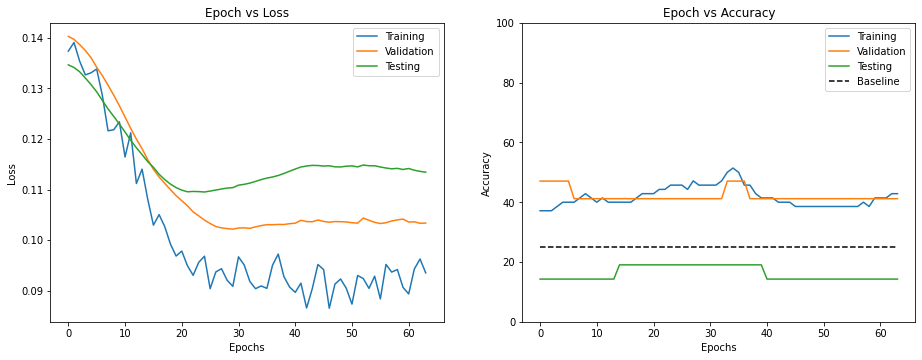

Train/Val/Test Final MSE: [0.09179500639438629, 0.10231204944498398, 0.11126946272062403]
Train/Val/Test Maximum Accuracy: [47.142857142857146, 41.1764705882353, 19.047619047619047]

5/5 Fold
----------------------------


-----Epoch  10 / 300
Train/Val/TEST MSE: 0.1238239735364914 0.1432556466144674 0.12078916547553879
Train/Val/TEST Accuracy: 42.857142857142854 29.41176470588235 28.571428571428573
-----Epoch  20 / 300
Train/Val/TEST MSE: 0.09810618162155152 0.1221387530950939 0.10809054651430675
Train/Val/TEST Accuracy: 42.857142857142854 29.41176470588235 23.80952380952381
-----Epoch  30 / 300
Train/Val/TEST MSE: 0.0928682878613472 0.11388838466475992 0.10934445900576455
Train/Val/TEST Accuracy: 41.42857142857143 35.294117647058826 28.571428571428573
-----Epoch  40 / 300
Train/Val/TEST MSE: 0.08395473510026932 0.11346068978309631 0.11266722654302914
Train/Val/TEST Accuracy: 42.857142857142854 35.294117647058826 28.571428571428573
-----Epoch  50 / 300
Train/Val/TEST MSE: 0.09143318682909012 0.11452543713590678 0.11384982606839567
Train/Val/TEST Accuracy: 50.0 29.41176470588235 23.80952380952381
-----Epoch  60 / 300
Train/Val/TEST MSE: 0.08926694691181183 0.11539771626977359 0.11142501110831897
Train/Va

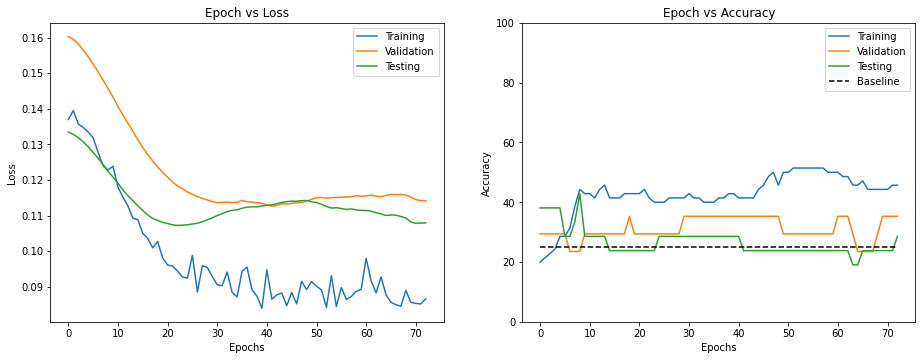

Train/Val/Test Final MSE: [0.08648088723421096, 0.11263068042257253, 0.11301349919466745]
Train/Val/Test Maximum Accuracy: [41.42857142857143, 35.294117647058826, 23.80952380952381]


In [9]:
# Model simulation
loss_K, acc_K, param_K, models_K = CerealTimeKillersModelSimulator(args, CerealTimeKillersLabels, 
                                                                   TrainDataLoader,
                                                                   ValDataLoader,
                                                                   TestDataLoader,
                                                                   DataSize,
                                                                   is_2D = Is_2D_to_quardrant_emotion,
                                                                   K_fold_train = K_fold_train,
                                                                   k_folds = k_folds)



In [10]:
# Average results from K-folds
print('Train/Val/Test Average MSE:', list(np.mean(np.array(loss_K), axis = 0)))
print('Train/Val/Test Average Accuracy:', list(np.mean(np.array(acc_K), axis = 0)))


Train/Val/Test Average MSE: [0.08871570855379105, 0.0986285799469044, 0.11115102202055001]
Train/Val/Test Average Accuracy: [42.53416149068323, 39.08496732026144, 24.761904761904763]


## Single prediction results

In [11]:
# Print single prediction results from data loader
fold = 0
ShowDataset = TestDataLoader
ShowModel = models_K[fold]
BATCH_SHOW = 20

ShowModel.eval()

with torch.no_grad():
    for idx, (data, target, quadrant) in enumerate(ShowDataset):
        data = data.type(torch.float).to(args['device'])
        target = target.type(torch.float).to(args['device'])
        quadrant = quadrant.type(torch.float).to(args['device'])
        output = ShowModel(data)
            
        eval_loss = criterion(output, target).item()
        
        if not Is_2D_to_quardrant_emotion:
            predicted = maximum_extraction(output)
            labels = maximum_extraction(target)
        else:
            predicted = emotion_transformation(output)
            flabels = maximum_extraction(quadrant)
            labels = emotion_transformation(target)
        
        eval_acc = maximum_comparison(predicted, labels) * 100.0 / target.size(0)
        
        if idx < BATCH_SHOW:
            print('Batch', idx + 1, ' ( Size', target.size(0), '):')
            print('Output Example:', output[0].detach().numpy(), 'with label ', predicted[0])
            if not Is_2D_to_quardrant_emotion:
                print('Target Example:', target[0].detach().numpy(), 'with label ', labels[0])
            else:
                print('Target Example:', target[0].detach().numpy(), 'with label ', flabels[0])
                print('Real Label Example:', quadrant[0].detach().numpy(), 'with label ', labels[0])
            print('------- MSE:', eval_loss, ' Accuracy:', eval_acc, '%-------\n')
        else:
            print('Etc. for totally ', len(ShowDataset), 'batches.')
            break
 

Batch 1  ( Size 1 ):
Output Example: [0.24126191 0.19939302 0.46255976 0.43713844] with label  [2]
Target Example: [0.         1.         0.11111111 0.        ] with label  [1]
------- MSE: 0.2534462511539459  Accuracy: 0.0 %-------

Batch 2  ( Size 1 ):
Output Example: [0.24954803 0.17278948 0.44128215 0.415046  ] with label  [2]
Target Example: [1. 0. 1. 0.] with label  [0, 2]
------- MSE: 0.2693657875061035  Accuracy: 100.0 %-------

Batch 3  ( Size 1 ):
Output Example: [0.1900308  0.14127995 0.46360552 0.4376177 ] with label  [2]
Target Example: [0.7777778  0.         0.22222222 0.        ] with label  [0]
------- MSE: 0.15379542112350464  Accuracy: 0.0 %-------

Batch 4  ( Size 1 ):
Output Example: [0.1915569  0.13802014 0.4660835  0.44185847] with label  [2]
Target Example: [0.         0.         0.44444445 0.7777778 ] with label  [3]
------- MSE: 0.04226341098546982  Accuracy: 0.0 %-------

Batch 5  ( Size 1 ):
Output Example: [0.21939646 0.1706461  0.46914846 0.44835475] with l

## 2D emotion plot

In [12]:
# Plot 2D emotions in a plane for all dataset
if Is_2D_to_quardrant_emotion:
    fold = 0 # select the model trained in the corresponding fold
    TwoD_emotion_plotting(args, models_K[fold], FullDataset, LabelRange, subject = 27, game = 4, plot_disk = True)
